# Adding Statistic Annotations

Sources and inspiration:


*   https://www.kaggle.com/code/tirendazacademy/penguin-dataset-data-visualization-with-seaborn#Penguin-Dataset:-Data-Visualization-with-Seaborn
*   https://seaborn.pydata.org/tutorial/categorical.html
* https://pandas.pydata.org/docs/user_guide/visualization.html
* https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00



If running this from Google Colab, uncomment the cell below and run it. Otherwise, just skip it.

In [1]:
# !pip install watermark
# !pip install statannotations

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


import numpy as np
from scipy.stats import mannwhitneyu

## Seaborn with statistics annotations

### Introduction

Many libraries are available in Python to clean, analyze, and plot data.
Python also has robust statistical packages which are used by thousands of other projects.

That said, if you wish, basically, to add statistics to your plots, with the beautiful brackets as you can see in papers
using R or other statistical software, there are not many options.


In this part, we will use `statannotations`, a package to add statistical significance annotations on seaborn
categorical plots.

Specifically, we will answer the following questions:
- How to add custom annotations to a seaborn plot?
- How to automatically format previously computed p-values in several different ways, then add these to a plot in a
  single function call?
- How to both perform the statistical tests and add their results to a plot, optionally applying a multiple comparisons
  correction method?

**DISCLAIMER**: This tutorial aims to describe *how to use a plot annotation library, not to teach statistics*. The
examples are meant only to illustrate the plots, not the statistical methodology, and we will not draw any conclusions
about the dataset explored.

A correct approach would have required the careful definition of a research question based, evaluation how the data acquisitions and
maybe, ultimately, different group comparisons and/or tests. Of course, the p-value is not the right answer for
everything either. *But the aim is to learn how to aproach this so you can later easily reuse the notebooks, charts and even share it with your research!*

### Preparing the tools
First, let's prepare the data we will use as example.

We make 3 subsets from the penguins data cleaned, split by 'species'. We also split one of the species by 'sex'.

In [2]:
# Load and clean penguins data
penguins = sns.load_dataset("penguins")
penguins_cleaned = penguins.dropna()

# Split penguins data by species
Adelie_values =  penguins_cleaned[penguins_cleaned['species']=='Adelie']
Chinstrap_values = penguins_cleaned[penguins_cleaned['species']=='Chinstrap']
Gentoo_values = penguins_cleaned[penguins_cleaned['species']=='Gentoo']

# Split 'Gentoo' species by sex
Gentoo_values_male=Gentoo_values[Gentoo_values.sex=='Male']
Gentoo_values_female=Gentoo_values[Gentoo_values.sex=='Female']

## Using statannotations
The general pattern is

0. Decide which pairs of data you would like to annotate


1. Instantiate an `Annotator` (or reuse it on a new plot, we'll cover that later)


2. Configure it (text formatting, statistical test, multiple comparisons correction method...)


3. Make the annotations (we'll cover these cases)

    - By providing completely custom annotations (A)
    - By providing pvalues to be formatted before being added to the plot (B)
    - By applying a configured test (C)


4. Annotate !

In [3]:
from statannotations.Annotator import Annotator

If we already have a seaborn plot (and its associated `axes`), and statistical results, or any other text we would like to
 display on the plot, these are the detailed steps required.

**STEP 0**: What to compare

A pre-requisite to annotating the plot, is deciding which pairs you are comparing.
You'll pass which boxes (or bars, violins, etc) you want to annotate in a `pairs` parameter. In this case, it is the
equivalent of `'Adelie vs Chinstrap'` and others.

For statannotations, we specify this as a list of tuples like `('Adelie', 'Chinstrap')`

```python
pairs = [('Adelie', 'Chinstrap'),
         ('Adelie', 'Gentoo'),
         ('Chinstrap', 'Gentoo'),
         ]
```
**STEP 1**: The annotator

We now have all we need to instantiate the annotator
```python
annotator = Annotator(ax, pairs, ...)  # With ... = all parameters passed to seaborn's plotter
```

**STEP 2**: In this first example, we will not configure anything.

**STEP 3**: We'll then add the raw pvalues from scipy's returned values
```python

pvalues = [mannwhitneyu(Adelie_values['bill_length_mm'], Chinstrap_values['bill_length_mm']).pvalue,
           mannwhitneyu(Adelie_values['bill_length_mm'], Gentoo_values['bill_length_mm']).pvalue,
           mannwhitneyu(Chinstrap_values['bill_length_mm'], Gentoo_values['bill_length_mm']).pvalue]
```
using
```python
annotator.set_custom_annotations(pvalues)
```
**STEP 4**: Annotate !
```python
annotator.annotate()
```

(*) Make sure pairs and annotations (pvalues here) are in the same order

[Text(0.5, 1.0, 'Bill Length for 3 Penguin Species')]

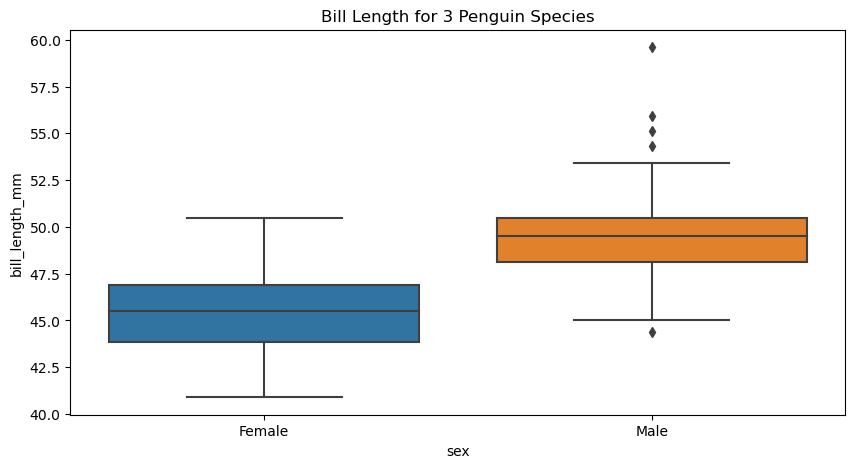

In [4]:
figure, axes = plt.subplots(figsize=(10, 5))

sns.boxplot(
    data = Gentoo_values,
    x = "sex",
    y = "bill_length_mm",
    ax = axes)

axes.set(title="Bill Length for 3 Penguin Species")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Female vs. Male: p=5.59e-13


[Text(0.5, 1.0, 'Bill Length for Gentoo, based on sex')]

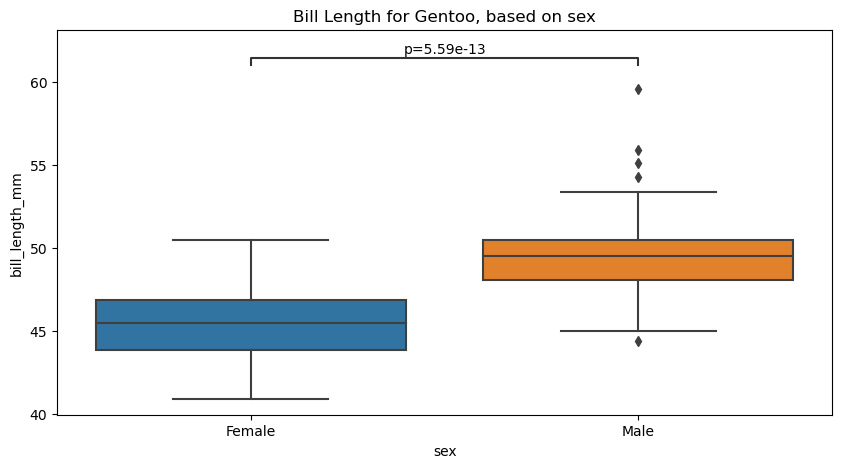

In [7]:
pairs = [('Female', 'Male'),
        #  ('data 1', 'data 2'),
         ]

# pvalues with scipy, format based on pairs:
stat_results_GMF = [mannwhitneyu(Gentoo_values_female['bill_length_mm'], Gentoo_values_male['bill_length_mm'], alternative="two-sided"),]
pvalues = [result.pvalue for result in stat_results_GMF]

formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

# Create new plot
figure, axes = plt.subplots(figsize=(10, 5))

plotting_parameters = {
    'data':Gentoo_values,
    'x':'sex',
    'y':'bill_length_mm',
}

# Plot with seaborn
sns.boxplot(ax=axes, **plotting_parameters)

# Add annotations
annotator = Annotator(ax=axes, pairs=pairs, **plotting_parameters)
annotator.set_custom_annotations(formatted_pvalues)
annotator.annotate()

axes.set(title="Bill Length for Gentoo, based on sex")

### Use statannotations to apply scipy test

Finally, `statannotations` can take care of most of the steps required to run the test by calling `scipy.stats` directly
and annotate the plot.
The available options are

- Mann-Whitney
- t-test (independent and paired)
- Welch's t-test
- Levene test
- Wilcoxon test
- Kruskal-Wallis test

We will cover how to use a test that is not one of those already interfaced in `statannotations`.
If you are curious, you can also take a look at the usage
[notebook](https://github.com/trevismd/statannotations/blob/master/usage/example.ipynb) in the project repository.

### Simple

Adelie vs. Chinstrap: Mann-Whitney-Wilcoxon test two-sided, P_val:9.063e-31 U_stat=1.000e+02
Chinstrap vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.947e-03 U_stat=5.105e+03
Adelie vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.022e-42 U_stat=2.160e+02


[Text(0.5, 1.0, 'Bill Length Comparison')]

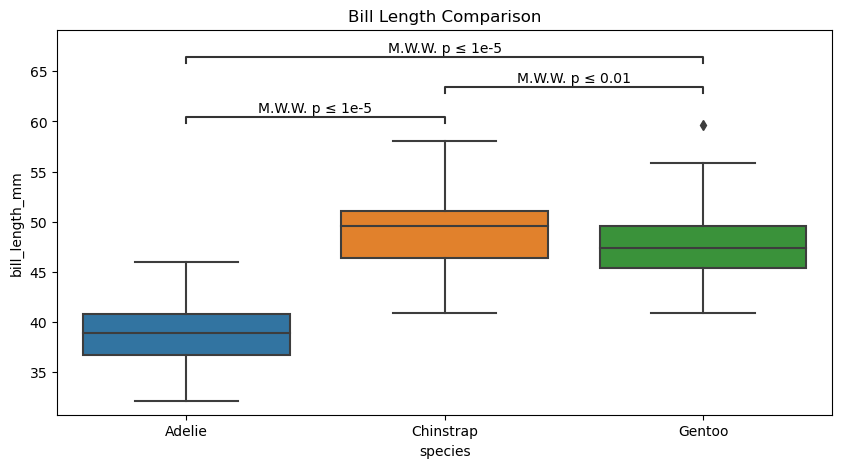

In [8]:
# Create new plot
figure, axes = plt.subplots(figsize=(10, 5))

plotting_parameters = {
    'data': penguins_cleaned,
    'x':'species',
    'y':'bill_length_mm',
}

pairs = [('Adelie', 'Chinstrap'),
         ('Adelie', 'Gentoo'),
         ('Chinstrap', 'Gentoo'),
         ]


# Plot with seaborn
sns.boxplot(ax=axes, **plotting_parameters)

# Add annotations
annotator.new_plot(ax=axes, pairs=pairs, **plotting_parameters)
annotator.configure(test='Mann-Whitney', text_format="simple", verbose=True).apply_and_annotate()

axes.set(title="Bill Length Comparison")

### Full

Adelie vs. Chinstrap: Mann-Whitney-Wilcoxon test two-sided, P_val:9.063e-31 U_stat=1.000e+02
Chinstrap vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.947e-03 U_stat=5.105e+03
Adelie vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.022e-42 U_stat=2.160e+02


[Text(0.5, 1.0, 'Bill Length Comparison')]

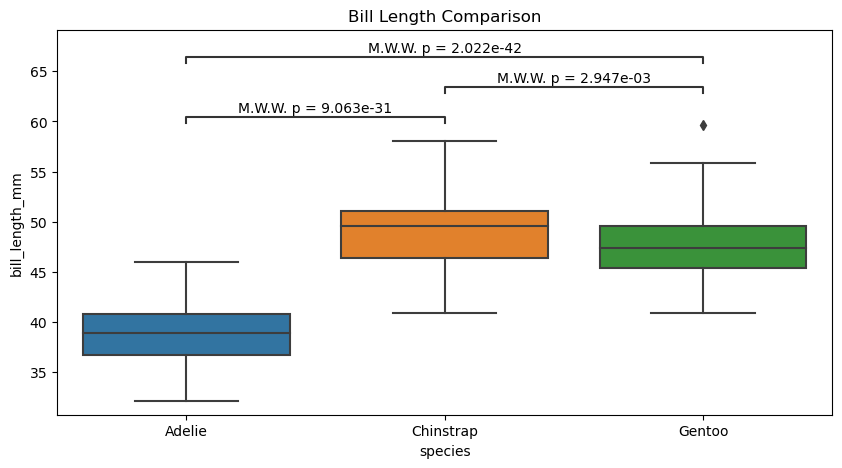

In [9]:
# Create new plot
figure, axes = plt.subplots(figsize=(10, 5))

plotting_parameters = {
    'data': penguins_cleaned,
    'x':'species',
    'y':'bill_length_mm',
}

pairs = [('Adelie', 'Chinstrap'),
         ('Adelie', 'Gentoo'),
         ('Chinstrap', 'Gentoo'),
         ]


# Plot with seaborn
sns.boxplot(ax=axes, **plotting_parameters)

# Add annotations
annotator.new_plot(axes, pairs=pairs, **plotting_parameters)
annotator.configure(test='Mann-Whitney', text_format="full", verbose=True).apply_and_annotate()

axes.set(title="Bill Length Comparison")

### Star

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adelie vs. Chinstrap: Mann-Whitney-Wilcoxon test two-sided, P_val:9.063e-31 U_stat=1.000e+02
Chinstrap vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.947e-03 U_stat=5.105e+03
Adelie vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.022e-42 U_stat=2.160e+02


[Text(0.5, 1.0, 'Bill Length Comparison')]

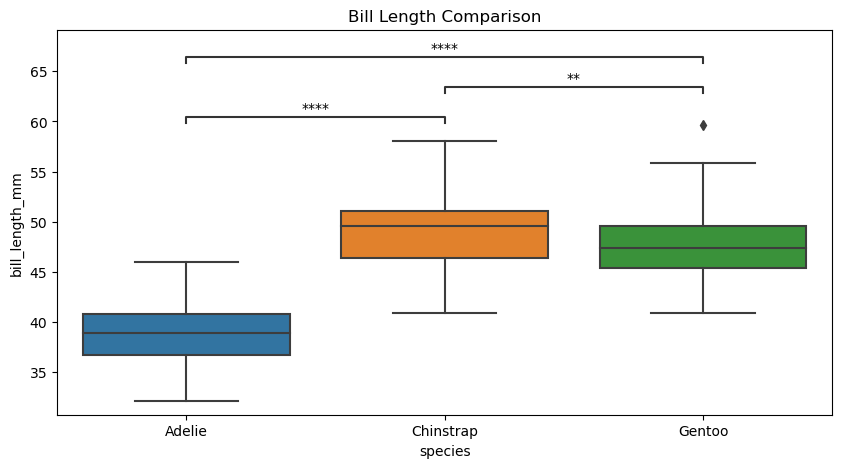

In [10]:
# Create new plot
figure, axes = plt.subplots(figsize=(10, 5))

plotting_parameters = {
    'data': penguins_cleaned,
    'x':'species',
    'y':'bill_length_mm',
}

pairs = [('Adelie', 'Chinstrap'),
         ('Adelie', 'Gentoo'),
         ('Chinstrap', 'Gentoo'),
         ]


# Plot with seaborn
sns.boxplot(ax=axes, **plotting_parameters)

# Add annotations
annotator.new_plot(ax=axes, pairs=pairs, **plotting_parameters)
annotator.configure(test='Mann-Whitney', text_format="star", verbose=True).apply_and_annotate()

axes.set(title="Bill Length Comparison")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adelie vs. Chinstrap: Mann-Whitney-Wilcoxon test two-sided, P_val:9.063e-31 U_stat=1.000e+02
Chinstrap vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.947e-03 U_stat=5.105e+03
Adelie vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.022e-42 U_stat=2.160e+02


[Text(0.5, 1.0, 'Bill Length Comparison of Penguin Species')]

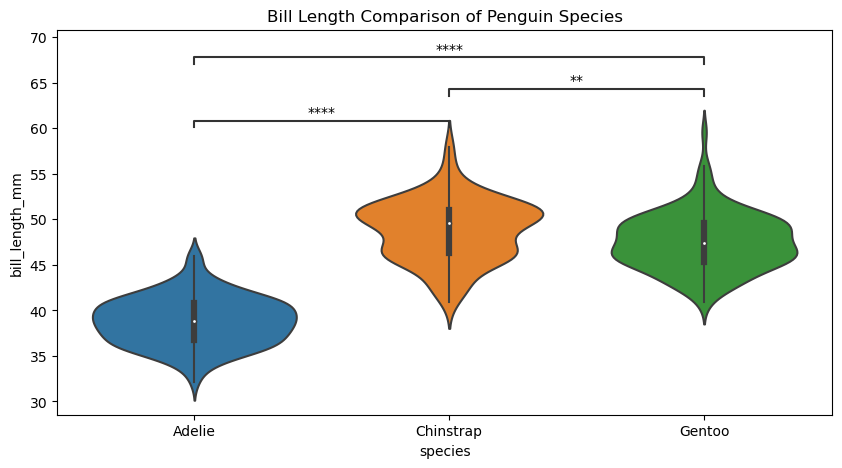

In [11]:
# Create new plot
figure, axes = plt.subplots(figsize=(10, 5))

plotting_parameters = {
    'data':penguins_cleaned,
    'x':'species',
    'y':'bill_length_mm',
}

pairs = [('Adelie', 'Chinstrap'),
         ('Adelie', 'Gentoo'),
         ('Chinstrap', 'Gentoo'),
         ]


# Plot with seaborn
sns.violinplot(ax=axes, **plotting_parameters)

# Add annotations
annotator.new_plot(ax=axes, pairs=pairs, **plotting_parameters)
annotator.configure(test='Mann-Whitney', text_format="star", verbose=True).apply_and_annotate()

axes.set(title="Bill Length Comparison of Penguin Species")

In [12]:
figure.savefig('violin_annotated_PNG.png', dpi=300)

---

In [13]:
from watermark import watermark
watermark(iversions=True, globals_=globals())
print(watermark())
print(watermark(packages="watermark,numpy,pandas,seaborn,matplotlib,scipy,statannotations"))

Last updated: 2023-08-25T19:06:19.247868+02:00

Python implementation: CPython
Python version       : 3.9.17
IPython version      : 8.14.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 16
Architecture: 64bit

watermark      : 2.4.3
numpy          : 1.23.5
pandas         : 2.0.3
seaborn        : 0.12.2
matplotlib     : 3.7.2
scipy          : 1.11.2
statannotations: 0.4.4

